# test for interpolation routine with feiss GPU

In [1]:
from torch import nn
import torch.nn.functional as F
import torch
import os
import sys
import matplotlib.pyplot as plt

In [2]:
# -----------------------------
# add "src" as import path
path = os.path.join('/home/tsuyoshi/local_transformation_model/src/')
sys.path.append(path)

In [3]:
import numpy as np
#from src_rev_bilinear.rev_bilinear_interp import RevBilinear
from nearest_neighbor_interp import nearest_neighbor_interp_fe

In [4]:
# plot a 2-d field
def plot_field(X,title,vmin=0,vmax=1):
    plt.imshow(X,vmin=vmin,vmax=vmax,cmap="GnBu",origin='lower')
    plt.colorbar()
    plt.grid()
    plt.title(title)
    plt.show()

In [5]:
def grid_to_pc_nearest(R_grd,XY_pc,XY_grd):
    # convert grid to pc
    # R_grd: grid value with [batch,channels,height,width] dim
    # XY_pc: point cloud position with [batch,2,N] dim
    #        scaled to [0,1]
    batch,k,height,width = R_grd.shape
    XY_grd_tmp = XY_grd.reshape(batch,2,height*width).permute(0,2,1).detach()
    XY_pc_tmp = XY_pc.permute(0,2,1).detach()
    R_grd_tmp = R_grd.reshape(batch,k,height*width)
    #R_pc = nearest_neighbor_interp(XY_pc_tmp,XY_grd_tmp,R_grd_tmp)
    #R_pc = nearest_neighbor_interp_kd(XY_pc_tmp,XY_grd_tmp,R_grd_tmp)
    R_pc = nearest_neighbor_interp_fe(XY_pc_tmp,XY_grd_tmp,R_grd_tmp)
    #import pdb;pdb.set_trace()
    return R_pc

In [6]:
def pc_to_grid_nearest(R_pc,XY_pc,XY_grd):
    # convert pc to grid
    # R_pc: point cloud value with [batch,channels,N] dim
    # XY_pc: point cloud position with [batch,2,N] dim
    #        scaled to [0,1]
    batch,_,height,width = XY_grd.shape
    _,k,_ = R_pc.shape
    XY_grd_tmp = XY_grd.reshape(batch,2,height*width).permute(0,2,1).detach()
    XY_pc_tmp = XY_pc.permute(0,2,1).detach()
    #R_grd = nearest_neighbor_interp(XY_grd_tmp,XY_pc_tmp,R_pc)
    #R_grd = nearest_neighbor_interp_kd(XY_grd_tmp,XY_pc_tmp,R_pc)
    #R_grd = nearest_neighbor_interp_kd(XY_pc_tmp,XY_grd_tmp,R_pc)
    R_grd = nearest_neighbor_interp_fe(XY_grd_tmp,XY_pc_tmp,R_pc)
    #import pdb;pdb.set_trace()
    R_grd = R_grd.reshape(batch,k,height,width)
    return R_grd

## Dims

In [91]:
bsize = 10
tsize = 12
channels = 1
# Grid Size
#height = 10
#width = 10
height = 200
width = 200
# Particle Size
npc = 40000

In [92]:
def xy_grid(height,width):
    # generate constant xy grid
    x1grd = torch.linspace(0,1,width).cuda() # 1d grid
    y1grd = torch.linspace(0,1,height).cuda() # 1d grid

    Xgrid = torch.zeros(height, width)
    Ygrid = torch.zeros(height, width)
    for j in range(height):
        Xgrid[j,:] = x1grd
    for k in range(width):
        Ygrid[:,k] = y1grd
    return Xgrid,Ygrid

## Prepare Grids

In [93]:
Xgrid,Ygrid = xy_grid(height,width)

In [94]:
# Set Initial Grid (which will be fixed through time progress)
X_grd = torch.stack(bsize*[Xgrid]).unsqueeze(1)
Y_grd = torch.stack(bsize*[Ygrid]).unsqueeze(1)
XY_grd = torch.cat([X_grd,Y_grd],dim=1).cuda()
# Set Initial PC
#XY_pc = torch.zeros(bsize,2,npc).cuda()
XY_pc = torch.rand(bsize,2,npc).cuda() #[0-1]

In [95]:
torch.max(XY_pc)

tensor(1.0000, device='cuda:0')

In [96]:
XY_pc.shape

torch.Size([10, 2, 40000])

In [97]:
XY_grd.shape

torch.Size([10, 2, 200, 200])

In [98]:
# Set initial rain field

In [99]:
ic=0.5
jc=0.5
scale=0.1
R_grd = torch.exp(-((X_grd-ic)**2 + (Y_grd-jc)**2)/scale**2)
R_grd = R_grd.cuda()

In [100]:
R_grd.shape

torch.Size([10, 1, 200, 200])

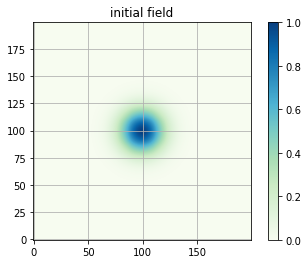

In [101]:
# test plot for initial grid
rtmp = R_grd[0,0,:,:].detach().cpu().numpy()
plot_field(rtmp,"initial field")

In [102]:
#set UV
UV_grd = torch.zeros(bsize,tsize, 2,height, width).cuda()
UV_grd = UV_grd + 0.03

In [103]:
# initialize R_pc
R_pc = grid_to_pc_nearest(R_grd[:,:,:,:],XY_pc,XY_grd)
# initialize 
R_grd_all = torch.zeros(bsize,tsize, 1,height, width).cuda()

In [104]:
%%time
#it = 0
# loop through time dim
for it in range(tsize):
    print("it=",it)
    # convert R and UV to point cloud
    UV_pc = grid_to_pc_nearest(UV_grd[:,it,:,:,:],XY_pc,XY_grd)
    # time progress
    XY_pc = XY_pc + UV_pc
    # go back to grid
    R_grd_all[:,it,:,:,:] = pc_to_grid_nearest(R_pc,XY_pc,XY_grd)

it= 0
it= 1
it= 2
it= 3
it= 4
it= 5
it= 6
it= 7
it= 8
it= 9
it= 10
it= 11
CPU times: user 59.6 s, sys: 2.74 s, total: 1min 2s
Wall time: 10.7 s


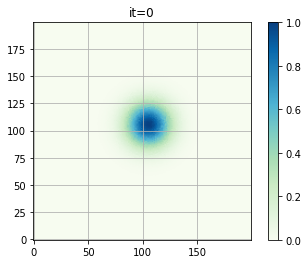

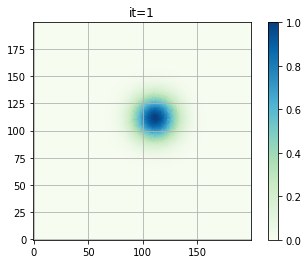

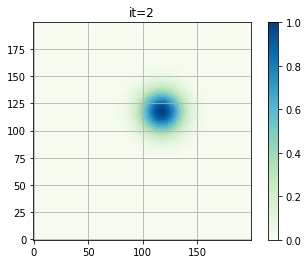

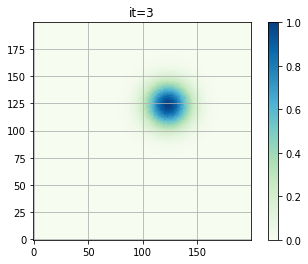

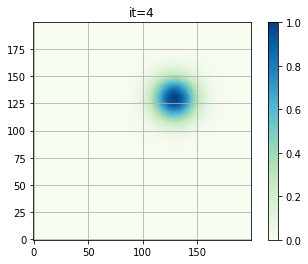

In [109]:
# test plot for time progress
for it in range(5):
    #it = 1
    rtmp = R_grd_all[0,it,0,:,:].detach().cpu().numpy()
    plot_field(rtmp,"it=%d" % it)

In [107]:
torch.max(XY_pc)
torch.max(XY_grd)
#torch.max(R_grd_all)

tensor(1., device='cuda:0')

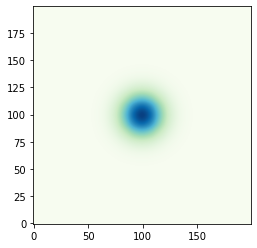

In [108]:
# Animation
#figオブジェクトを作る
fig = plt.figure()
#空のリストを作る
ims = []
#10個の画像を繋げたアニメーションにする
for it in range(tsize):
    #1枚1枚のグラフを描き、appendしていく
    title="it=%d" % i
    #X = #R_grd_all[0,it,0,:,:].detach().cpu().numpy()
    X = R_grd[0,0,:,:].detach().cpu().numpy()
    im = plt.imshow(X,vmin=0,vmax=1,cmap="GnBu",origin='lower')
    #plt.colorbar()
    #plt.grid()
    #plt.title(title)
    ims.append(im)     
#アニメーション作成 
ani = animation.ArtistAnimation(fig, ims, interval=200, repeat_delay=1000)
plt.show()